![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

# Fonctions d'activation
## Mise en situation
Toujours salarié à la poste, préposé aux algorithmes de reconnaissance des codes postaux :)

Le but du jour sera de faire évoluer un peu mon modèle pour voir si on peut faire mieux.

## Les fonctions d'activation
### Rappel
Il est nécessaire on l'a vu d'avoir dans nos réseaux de neurones une fonction d'activation pour casser la linéarité du calcul. On a utilisée jusque là la sigmoïde $\sigma(x) = \frac{1}{1+e^{-x}}$

On va en introduire d'autres.

### Pourquoi la sigmoïde
La sigmoïde avait été introduite avec les régressions logistiques. Il nous fallait une fonction qui renvoie une probabilité à partir d'un nombre réel.

On aurait pu penser à un échelon Heaviside, mais c'est trop "plat". Avec une sigmoïde, on sait au moins de quel côté évoluer pour améliorer. Un échelon a une dérivée nulle presque partout et donc l'utilisation du gradient sera compromise.

### Tangente hyperbolique
Pour les cas où on n'a pas de besoin particulier d'une valeur entre 0 et 1, on peut utiliser la tangente hyperbolique. C'est une version un peu étirée de la sigmoïde, à valeur entre -1 et 1.

> $tanh(x) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$

### ReLU
La fonction ReLU (**Re**gularized **L**inear **U**nit) ressemble à:
* une fonction nulle pour les valeurs x<0
* une fonction identité (f(x)=x) pour x>=0

Elle est linéaire sur les deux parties, mais la cassure en 0 est suffisante pour assurer un comportement non linéaire au final.

Note: on peut utiliser au lieu de l'identité n'importe quelle fonction linéaire, mais bon en vrai on s'en fiche : si je renvoie $2x$ au lieu de $x$, les poids des neurones qui consomment mon ReLU seront divisés par 2 automatiquement quand on fera la descente de gradient alors autant rester simple.

### Les trois fonctions

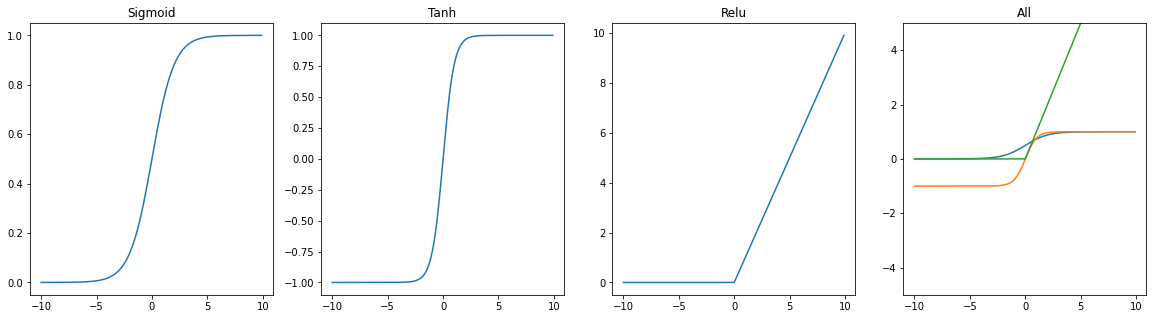

In [2]:
def sigmoid(x) : return 1 / (1 + np.exp(-x))
def tanh(x): return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
def relu(x): return np.maximum(x, 0)

x = np.arange(-10, 10, .1)
fig = plot.figure(figsize=(20,5))

fig.add_subplot(141)
plot.plot(x, sigmoid(x))
plot.title('Sigmoid')

fig.add_subplot(142)
plot.plot(x, tanh(x))
plot.title('Tanh')

fig.add_subplot(143)
plot.plot(x, relu(x))
plot.title('Relu')

ax=fig.add_subplot(144)
plot.ylim(-5, 5)
plot.plot(x, sigmoid(x))
plot.plot(x, tanh(x))
plot.plot(x, relu(x))
plot.title('All')

plot.show()

### Les dérivées

La dérivée de la sigmoïde est $\sigma'(x) = \sigma(x).(1-\sigma(x))$

On vérifiera que la dérivée de la tangente hyperbolique vaut $tanh'(x) = 1-tanh(x)^2$

Pour la ReLU, la fonction est continue mais pas dérivable partout : la cassure en 0 ne permet pas de calculer une dérivée. Par convention, on n'aura qu'à dire que la dérivée en 0 vaut 0, on s'en fiche un peu. Et donc au final on aura la dérivée $relu'(x) = \begin{cases}
x \leq 0 : 0\\
x \gt 0 : 1\\
\end{cases}$

Un gros avantage du ReLU sur les deux autres : dans le sens avant, ReLU n'est qu'un simple filtre "0 ou x", et en marche arrière sa dérivée est "0 ou 1". C'est une fonction vachement rapide à calculer, comparée aux deux autres avec des exp et des divisions dans tous les sens !

On va maintenant remplacer la première couche du réseau de neurones d'hier par la même avec une fonction d'activation différente. Pour la seconde, on garde une sigmoïde, pour tomber entre 0 et 1 c'est encore le mieux.

## Simulation rapide
Validons rapidement le concept avec une comparaison du XOR dans les 3 cas. Une précision : pour éviter des débordements, on va introduire un nouveau facteur qui indique l'amplitude du choix aléatoire initial (on génère des réels entre 0 et ce facteur quoi). Il est crucial pour converger rapidement, et dépend beaucoup de la dimension du réseau. On verra dans la semaine comment bien choisir le facteur en question. Mais pour faire court: ReLU peut donner une valeur aussi grande que l'on veut, elle n'est pas majorée par 1, et du coup une sigmoide appliquée par dessus donnera un résultat infinitésimalement proche de 0 ou de 1 (suivant le signe du W correspondant), mais enfin bref on risque de se retrouver avec une division par zéro si on dépasse la précision autorisée par Python. Et pour résoudre (en partie) le problème, on peut partir de poids beaucoup plus petits.

In [3]:
def forward_pass(X, W, b, activation):
    Z = np.dot(W, X) + b
    if activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'tanh':
        A = tanh(Z)
    elif activation == 'relu':
        A = relu(Z)
    return Z, A

def backward_pass(dA, A, Z, A_prev, W, activation):
    # Note: on pourrait ne passer que Z, A vaut sigmoid, tanh ou relu de Z, mais bon gagnons du temps de calcul...
    if activation == 'sigmoid':
        dZ = dA * A * (1 - A)
    elif activation == 'tanh':
        dZ = dA * (1 - A**2)
    elif activation == 'relu':
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

    dW = np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    return dZ, dW, db, dA_prev

def double_layer_model(X, Y, mid_layer, class_count, learning_rate = 0.0075, num_iterations = 3000,
                       batch_size = 64, first_layer_activation = 'sigmoid', random_range = 1):
    m = X.shape[1]
    batchStart = 0
    costs = []

    W1 = np.random.rand(mid_layer, X.shape[0]) * random_range
    b1 = np.zeros((mid_layer, 1))
    W2 = np.random.rand(class_count, mid_layer) * random_range
    b2 = np.zeros((class_count, 1))


    for i in range(1, num_iterations+1):
        Xbatch = X[:,batchStart:batchStart + batch_size]
        Ybatch = Y[:,batchStart:batchStart + batch_size]
        
        # Passe en avant
        Z1, A1 = forward_pass(Xbatch, W1, b1, activation = first_layer_activation)
        Z2, A2 = forward_pass(A1,     W2, b2, activation = 'sigmoid')

        # Calcul du cout (juste pour voir)
        if (i+1) % 10 == 0:
                cost = np.squeeze(-np.sum(np.log(A2) * Ybatch + np.log(1 - A2) * (1-Ybatch))/Xbatch.shape[1])
                costs.append(cost)

        dA2 = -(np.divide(Ybatch, A2) - np.divide(1 - Ybatch, 1 - A2))/Xbatch.shape[1]

        dZ2, dW2, db2, dA1 = backward_pass(dA2, A2, Z2, A1,     W2, activation = 'sigmoid')
        dZ1, dW1, db1, dX  = backward_pass(dA1, A1, Z1, Xbatch, W1, activation = first_layer_activation)

        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        batchStart += batch_size
        if batchStart >= X.shape[1]:
            batchStart = 0
        
    return W1, b1, W2, b2, costs

def model(X, W1, b1, W2, b2, first_layer_activation = 'sigmoid') :
    Z1, A1 = forward_pass(X, W1, b1, activation = first_layer_activation)
    Z2, A2 = forward_pass(A1, W2, b2, activation='sigmoid')
    return A2

On y va pour l'entrainement du XOR, dans les 3 cas.

sigmoid: final cost is 0.014208
0 xor 0 = 0
0 xor 1 = 1
1 xor 0 = 1
1 xor 1 = 0
tanh: final cost is 0.003210
0 xor 0 = 0
0 xor 1 = 1
1 xor 0 = 1
1 xor 1 = 0
relu: final cost is 0.346731
0 xor 0 = 1
0 xor 1 = 1
1 xor 0 = 1
1 xor 1 = 0


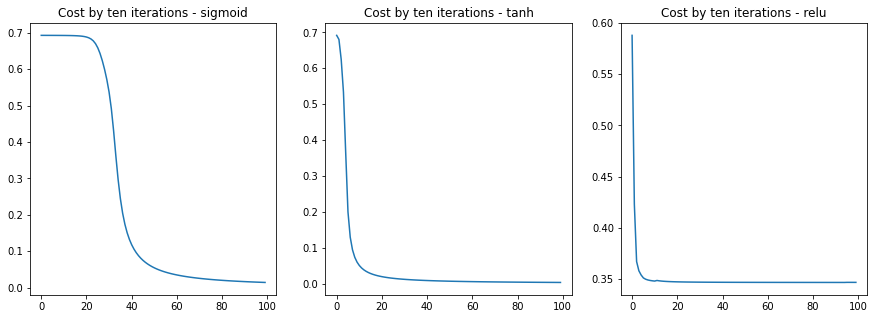

In [4]:
x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0,1,1,0]])

x_norm = (x - x.mean(axis=0))/(1e-9 + x.std(axis = 0))
x_norm = x_norm.T

def simulation(activation, figure, i) :
    np.random.seed(1)
    W1, b1, W2, b2, costs = double_layer_model(x_norm, y, 2,1, learning_rate = 1, 
                    num_iterations = 1000, first_layer_activation = activation)
    figure.add_subplot(1, 3, i)
    plot.plot(range(len(costs)), costs)
    plot.title('Cost by ten iterations - ' + activation)
    print('%s: final cost is %f'%(activation, costs[-1]))

    xor_result = model(x_norm, W1, b1, W2, b2, first_layer_activation = activation)
    for i in range(4):
        print("%i xor %i = %i" %(x[i,0], x[i,1], xor_result[0,i]>.5))

fig = plot.figure(figsize=(15,5))
acts = ['sigmoid', 'tanh', 'relu']
for i in range(len(acts)):
    simulation(acts[i], fig, i+1)
plot.show()


Il y a donc une convergence beaucoup plus rapide dans le cas de tanh, et une convergence encore plus rapide sur ReLU, **mais** un très gros biais, dans ce cas précis.

En tous les cas, ça converge quelque part.

## Retour à la mise en situation

### Chargement des données

On continue avec le dataset de Yann Le Cun http://yann.lecun.com/exdb/mnist/ (images 28x28, 60.000 données d'entrainement et 10.000 données de validation)

In [5]:
def load(file): 
    data = np.load(file)
    return data['x'], data['y']

x_train, y_train = load('data/d09_train_data.npz')
x_test , y_test  = load('data/d09_test_data.npz')

m,n = x_train.shape

print('%i training samples loaded of size %i' % (m, n))
print('%i test samples loaded' %(x_test.shape[0]))

60000 training samples loaded of size 784
10000 test samples loaded


On normalise ...

In [6]:
mus = x_train.mean(axis = 0)
sigmas = x_train.std(axis = 0)

x_train_norm = (x_train-mus)/(1e-9 +sigmas)
x_test_norm = (x_test-mus)/(1e-9 +sigmas)

y_train_mat = (y_train == np.arange(10)).astype(int)

Go, on entraine 3 modèles avec chacune des fonctions et on compare

In [7]:
def simulation(act, iterations):

    np.random.seed(1)
    W1, b1, W2, b2, costs = double_layer_model(x_train_norm.T, y_train_mat.T, 30, 10, learning_rate = .1,
                                      num_iterations = iterations, batch_size = 64, random_range = .04,
                                               first_layer_activation = act)
    plot.title('Cost by ten iterations')
    plot.plot(range(len(costs)), costs)
    plot.show()

    y_model_train = model(x_train_norm.T, W1, b1, W2, b2, first_layer_activation = act)
    y_train_result = np.argmax(y_model_train, axis = 0).reshape(-1, 1)
    train_ratio = np.mean(y_train_result == y_train)
    print("Accuracy on training set : %f%%" % (100 * train_ratio))

    y_model_test = model(x_test_norm.T, W1, b1, W2, b2, first_layer_activation = act)
    y_test_result = np.argmax(y_model_test, axis = 0).reshape(-1, 1)
    test_ratio = np.mean(y_test_result == y_test)
    print("Accuracy on test set : %f%%" % (100 * test_ratio))

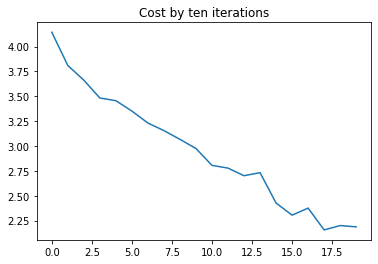

Accuracy on training set : 66.696667%
Accuracy on test set : 67.150000%


In [8]:
simulation('sigmoid', 200)

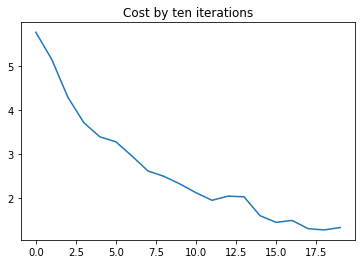

Accuracy on training set : 86.645000%
Accuracy on test set : 86.980000%


<ipython-input-2-0fe9ec81abcf>:2: RuntimeWarning: overflow encountered in exp
  def tanh(x): return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
<ipython-input-2-0fe9ec81abcf>:2: RuntimeWarning: invalid value encountered in true_divide
  def tanh(x): return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))


In [9]:
simulation('tanh', 200)

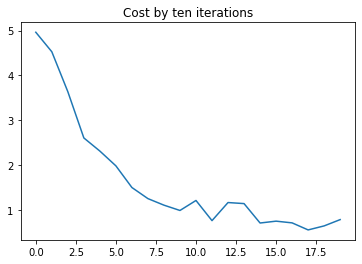

Accuracy on training set : 89.370000%
Accuracy on test set : 89.670000%


<ipython-input-2-0fe9ec81abcf>:1: RuntimeWarning: overflow encountered in exp
  def sigmoid(x) : return 1 / (1 + np.exp(-x))


In [10]:
simulation('relu', 200)

On remarque que la sigmoïde, qui donnait de bons résultats hier, est en fait pas si géniale que ça : ok, ça converge. Mais avec 200 itérations, on n'a pas un résultat exceptionnel...

Avec du tanh, et toujours sur 200 itérations, on a quand même 87/88%.

Et surprise, avec la ReLU et 200 itérations, on fait encore mieux.

Ca met en valeur un principe clef du machine learning. Ce qui marche bien sur un modèle ne marchera pas forcément bien dans un autre cas. Le ReLU peut paraitre mauvais comparé à un traitement du XOR, ou simplement pas adapté. Mais dans un autre type de problème il sera efficace.

Un autre principe : il vaut mieux trouver des astuces et des conditions de convergence **rapide**. Ca permet essentiellement de faire des itérations rapides "on teste et on avise". Exemples et contre-exemples:
* Entrainer un modèle pendant 5 jours sur du ReLU dans le cas du XOR pour voir qu'on a un souci de biais, c'est moche.
* Entrainer un modèle 5 minutes sans pouvoir prédire son comportement, c'est inutile.
* Entrainer de la reconnaissance de chiffres sur peu d'itérations et plusieurs fonctions d'activations, pour valider que ReLU se comporte mieux, permet ensuite lancer un entraînement beaucoup plus long.

Le modèle n'est pas forcément meilleur, mais on converge plus vite. Et comme on l'a dit, un gros avantage de ReLU est d'être calculable très rapidement aussi, donc chaque itération prendra en plus moins de temps! Dans des problèmes beaucoup plus complexes, la convergence ne s'atteind pas en quelques secondes : du coup toute technique qui permet de converger plus vite est bonne à prendre ! Et on en verra encore d'autres.